In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

train_dir = '/Users/chaitrabhat/Final_project/dataset/train80'
test_dir = '/Users/chaitrabhat/Final_project/dataset/test20'
categories = ['Panama Disease','cordana','healthy','pestalotiopsis','sigatoka','xamthomonas']
img_size = (250, 250)
batch_size = 32
# ImageDataGenerators with ResNet50 preprocessing
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow from directory
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
class_labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))

# Load ResNet50 model
base_model = ResNet50(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Optional: freeze some layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(len(categories), activation='softmax')
])
# Compile model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Train model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=25,
    callbacks=[early_stopping],
    class_weight=class_weights
)


Found 4800 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


/Users/chaitrabhat/Banana_Project/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.6239 - loss: 3.4232
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9455 - loss: 2.3187
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9524 - loss: 2.0405
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9608 - loss: 1.7838
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9720 - loss: 1.5353
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 609s 4s/step - accuracy: 0.9761 - loss: 1.3149
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 531s 4s/step - accuracy: 0.9797 - loss: 1.1236
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.9809 - loss: 0.9553
Epoch 9/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.9823 - loss: 0.8166
Epoch 10/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.9829 - loss: 0.6896
Epoch 11/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.9819 - loss: 0.5893
Epoch 12/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 

38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 763ms/step - accuracy: 0.9785 - loss: 0.1583



 Final Test Accuracy: 0.9733 | Test Loss: 0.1675
 Final Training Accuracy: 0.9904


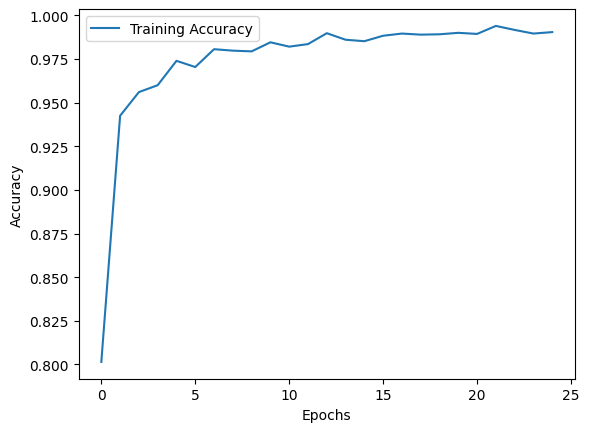

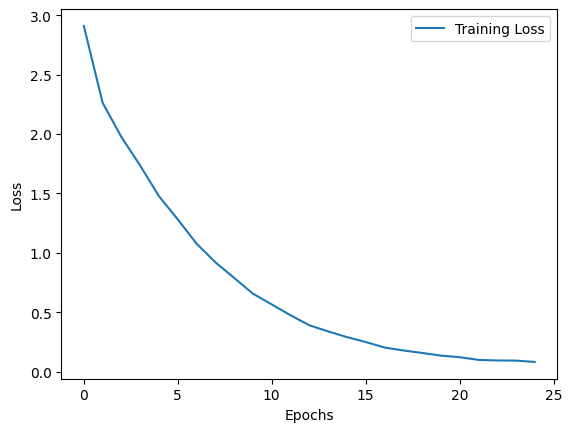


 Predicting test data for evaluation...
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 829ms/step

 Classification Report:
                precision    recall  f1-score   support

Panama Disease     0.9850    0.9850    0.9850       200
       cordana     1.0000    1.0000    1.0000       200
       healthy     0.9500    0.9500    0.9500       200
pestalotiopsis     0.9898    0.9750    0.9824       200
      sigatoka     0.9612    0.9900    0.9754       200
   xamthomonas     0.9543    0.9400    0.9471       200

      accuracy                         0.9733      1200
     macro avg     0.9734    0.9733    0.9733      1200
  weighted avg     0.9734    0.9733    0.9733      1200


 Confusion Matrix:


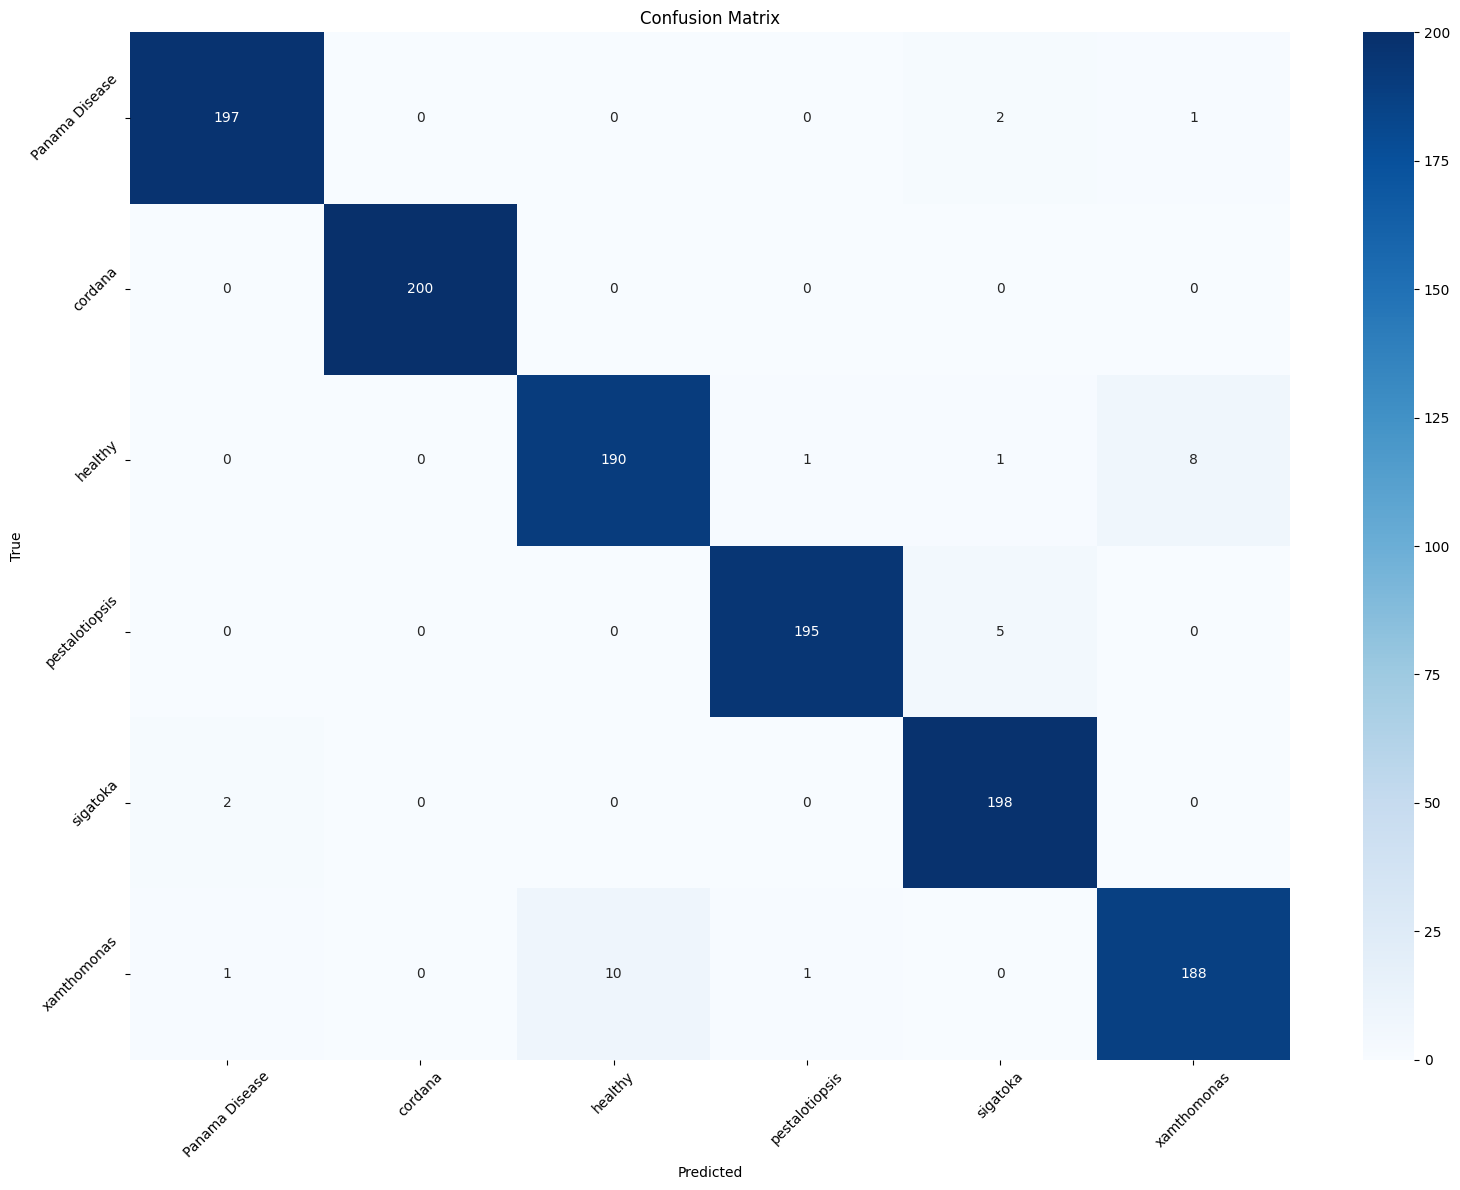

In [8]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"\n Final Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")
train_accuracy = history.history['accuracy'][-1]
print(f" Final Training Accuracy: {train_accuracy:.4f}")
# Save model
model.save('/Users/chaitrabhat/Final_project/models/ResNet50_banana_classification_model80.h5')
# Plot accuracy & loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n Predicting test data for evaluation...")
y_true = test_data.classes
y_probs = model.predict(test_data)
y_pred = np.argmax(y_probs, axis=1)

print("\n Classification Report:")
report = classification_report(y_true, y_pred, target_names=categories, digits=4)
print(report)

print("\n Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Prediction Function
def predict_image(image_path):
    from tensorflow.keras.utils import load_img, img_to_array
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    class_idx = tf.argmax(predictions[0]).numpy()
    return categories[class_idx]

# Test the prediction function
sample_image_path = '/Users/chaitrabhat/Final_project/dataset/test20/Panama Disease/0001.jpg'
print("Predicted Class:", predict_image(sample_image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
Predicted Class: Panama Disease
